In [434]:
### Splitting the data into train and validation set

In [1]:
#!g1.1
import utils

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image

from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.models.detection.mask_rcnn


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import cv2
from PIL import Image
import os
import functools as ft
import math
import sys
import time
import json


from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import train_one_epoch, _get_iou_types

import warnings
warnings.filterwarnings('ignore')

from torchvision.ops import batched_nms
from engine import evaluate

In [2]:
#!g1.1
class StampDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None, train=True):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train=train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms is not None:  #Apply transformation
            image = self.transforms(image)
        if(self.train==False):  # For test data
            return image, image_id
        #Else for train and validation data
        records = self.df[self.df['image_id'] == image_id]   
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
           
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = records['labels'].values
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        return image, target
    
    
def nms_evaluate(model, data_loader, device, confidence_threshold, nms_iou_threshold):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        model_outputs = model(images)

        nms_outputs = []
        for i in model_outputs:
            boxes = i['boxes'][i['scores'] > confidence_threshold]
            labels = i['labels'][i['scores'] > confidence_threshold]
            scores = i['scores'][i['scores'] > confidence_threshold]

            dict_predict = {}
            dict_predict['boxes'] = boxes
            dict_predict['labels'] = labels
            dict_predict['scores'] = scores

            indexes_nms = batched_nms(boxes, scores, labels, nms_iou_threshold)

            predict_nms = {}
            predict_nms['boxes'] = torch.index_select(dict_predict['boxes'], 0, indexes_nms)
            predict_nms['labels'] = torch.index_select(dict_predict['labels'], 0, indexes_nms)
            predict_nms['scores'] = torch.index_select(dict_predict['scores'], 0, indexes_nms)
            predict_nms
            
            nms_outputs.append(predict_nms)
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in nms_outputs]
        
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return targets, outputs, res, coco_evaluator

In [503]:
#!g1.1
from config import INPUT_DIR, DEVICE, NUM_EPOCHS, PATH_TO_MODEL_WEIGHTS, CONFIDENCE_THRESHOLD, NMS_IOU_THRESHOLD

In [5]:
#!g1.1
preprocessed_data = pd.read_csv('res_df')
preprocessed_data.head(3)

,image_id,bbox,x,y,w,h,labels,width,height,coords_sorted,x_min,y_min,x_max,y_max
0,img_0_1_1088.jpg,[0.1736 0.62862 0.30199 0.66447],184.36320,942.9300,320.71338,996.70500,1,1062,1500,[184.3632 942.93 320.71338 996.705 ],184,943,321,997
1,img_0_1_1088.jpg,[0.67089 0.62606 0.8264 0.67087],712.48518,939.0900,877.63680,1006.30500,1,1062,1500,[ 712.48518 939.09 877.6368 1006.305 ],712,939,878,1006
2,img_0_1_1089.jpg,[0.22242 0.54532 0.33996 0.58717],535.80978,1873.1742,818.96364,2016.92895,1,2409,3435,[ 535.80978 1873.1742 818.96364 2016.92895],536,1873,819,2017


In [6]:
#!g1.1
# Разделение датасета на выборки, создание даталоадеров
image_ids = preprocessed_data['image_id'].unique()

train_num = round(len(image_ids)*0.8)
valid_num = round((len(image_ids) - train_num)/2)

#random.shuffle(image_ids)

train_ids = image_ids[:train_num]
valid_ids = image_ids[train_num:(train_num+valid_num)]
test_ids = image_ids[(train_num+valid_num):]

train_df = preprocessed_data[preprocessed_data['image_id'].isin(train_ids)]
valid_df = preprocessed_data[preprocessed_data['image_id'].isin(valid_ids)]
test_df = preprocessed_data[preprocessed_data['image_id'].isin(test_ids)]

test_df.to_csv('test_df.csv', index=False)

trans = transforms.Compose([transforms.ToTensor()])   

train_dataset = StampDataset(train_df, INPUT_DIR, trans, True)
valid_dataset = StampDataset(valid_df, INPUT_DIR, trans, True)
test_dataset = StampDataset(test_df, INPUT_DIR, trans, True)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

In [44]:
#!g1.1
# Загрузка модели, предобученной на датасете COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Количество классов (печать, подпись и фон)
num_classes = 3 

# Изменение архитектуры выхода модели с учетом количества классов
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(DEVICE)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [12]:
# from torch.utils.tensorboard import SummaryWriter

# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('tensorboard_experiment_1')

In [16]:
#!g1.1
# ОБУЧЕНИЕ
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

tr_loss = []
val_score = []
val_loss = []

for epoch in range(NUM_EPOCHS):
    
    # 1. Обучение на тренировочном датасете (вывод лоссов каждые 10 итераций)
    training_data = train_one_epoch(model, optimizer, train_data_loader, DEVICE, epoch, print_freq=10)
    print("Training Loss: ", str(training_data.loss)[:7])
    tr_loss.append((training_data.meters['loss_classifier'].value +\
                    training_data.meters['loss_box_reg'].value +\
                    training_data.meters['loss_objectness'].value +\
                    training_data.meters['loss_rpn_box_reg'].value) / (len(training_data.meters) - 2))

    # 2. Обновление learning rate
    lr_scheduler.step()
    
    # 3. Рассчет метрик на валидационном датасете
    _, epoch_val_score = evaluate(model, valid_data_loader, device=DEVICE)
    print("Validation score:", epoch_val_score)
    val_score.append(epoch_val_score)
    
    # 4. Рассчет loss'ов на валидационном датасете
    val_loss_epoch = []
    model.train()
    for images, targets in valid_data_loader:
        images = [image.to(DEVICE) for image in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            val_loss_dict = model(images, targets)
            print('val_loss_dict: ', val_loss_dict)
            
            losses = (sum(val_loss_dict.values()) / len(val_loss_dict)).cpu().numpy().tolist()
            
            val_loss_epoch.append(losses)
    
    val_loss.append(sum(val_loss_epoch) / len(val_loss_epoch))
    
# Запись loss'ов для tensorboard'а   
#     writer.add_scalar('training loss',
#                       tr_loss,
#                       epoch)

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [  0/126]  eta: 0:02:54  lr: 0.000045  loss: 1.1123 (1.1123)  loss_classifier: 0.9290 (0.9290)  loss_box_reg: 0.1005 (0.1005)  loss_objectness: 0.0743 (0.0743)  loss_rpn_box_reg: 0.0085 (0.0085)  time: 1.3823  data: 0.4639  max mem: 9735
Epoch: [0]  [ 10/126]  eta: 0:03:25  lr: 0.000445  loss: 0.8211 (0.7948)  loss_classifier: 0.5649 (0.5467)  loss_box_reg: 0.1048 (0.1163)  loss_objectness: 0.0836 (0.1209)  loss_rpn_box_reg: 0.0095 (0.0108)  time: 1.7698  data: 0.8363  max mem: 14179
Epoch: [0]  [ 20/126]  eta: 0:03:03  lr: 0.000844  loss: 0.5084 (0.7058)  loss_classifier: 0.2304 (0.3864)  loss_box_reg: 0.1520 (0.1624)  loss_objectness: 0.0776 (0.1354)  loss_rpn_box_reg: 0.0095 (0.0216)  time: 1.7486  data: 0.8249  max mem: 14943
Epoch: [0]  [ 30/126]  eta: 0:02:52  lr: 0.001244  loss: 0.4907 (0.6472)  loss_classifier: 0.1964 (0.3271)  loss_box_reg: 0.2462 (0.1979)  loss_objectness: 0.0319 (0.1039)  loss_rpn_box_reg: 0.0094 (0.0183)  time: 1.8114  data: 0.8624  max mem: 149

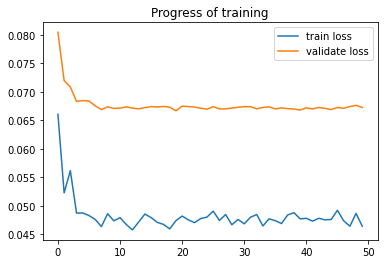

In [444]:
#!g1.1
x1 = [i for i in range(NUM_EPOCHS)]
y1 = tr_loss
plt.plot(x1, y1, label = "train loss")
x2 = [i for i in range(NUM_EPOCHS)]
y2 = val_loss
plt.plot(x2, y2, label = "validate loss")
plt.title('Progress of training')
plt.legend()
plt.savefig('Progress_of_training.png')
plt.show()

In [504]:
# #!g1.1
# x3 = [i for i in range(NUM_EPOCHS)]
# y3 = val_score
# plt.plot(x3, y3, label = "validate score")
# plt.xlabel('epoch')
# plt.title('Progress of scoring')
# plt.legend()
# plt.savefig('Progress_of_scoring.png')
# plt.show()

In [50]:
# #!g1.1
# # Сохранение весов модели
# os.makedirs(ft.reduce(os.path.join, ['weights_of_models']), exist_ok=True)
# path_for_weights = ft.reduce(os.path.join, ['weights_of_models',
#                                             '{}_epoсhs:{}_weights.pth'.format(get_date(), NUM_EPOCHS)])
# torch.save(model.state_dict(), path_for_weights)

In [9]:
#!g1.1
# Загрузка сохраненных весов модели
from engine import train_one_epoch, _get_iou_types
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load(ft.reduce(os.path.join, ['weights_of_models', PATH_TO_MODEL_WEIGHTS]),
                                 map_location=torch.device('cpu')))
model.eval()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet50-0676ba61.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [12]:
#!g1.1
evaluate(model, valid_data_loader, DEVICE)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:21  model_time: 0.4167 (0.4167)  evaluator_time: 0.0105 (0.0105)  time: 1.3742  data: 0.8599  max mem: 3878
Test:  [15/16]  eta: 0:00:01  model_time: 0.4062 (0.3901)  evaluator_time: 0.0105 (0.0113)  time: 1.2274  data: 0.7500  max mem: 5339
Test: Total time: 0:00:19 (1.2275 s / it)
Averaged stats: model_time: 0.4062 (0.3901)  evaluator_time: 0.0105 (0.0113)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.510
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.861
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.526
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.497
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.508
Average Recall     (AR) @[ IoU=0.50:0.

In [13]:
#!g1.1
evaluate(model, test_data_loader, DEVICE)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.3518 (0.3518)  evaluator_time: 0.0108 (0.0108)  time: 0.9406  data: 0.5209  max mem: 5339
Test:  [15/16]  eta: 0:00:01  model_time: 0.4188 (0.4197)  evaluator_time: 0.0109 (0.0132)  time: 1.3395  data: 0.8226  max mem: 5407
Test: Total time: 0:00:21 (1.3396 s / it)
Averaged stats: model_time: 0.4188 (0.4197)  evaluator_time: 0.0109 (0.0132)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.852
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.508
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.462
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.519
Average Recall     (AR) @[ IoU=0.50:0.

In [518]:
#!g1.1
#!g1.1
from engine import _get_iou_types
targets, outputs, res, coco_evaluator = nms_evaluate(model, test_data_loader, DEVICE, 0.85, 0.2)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.3719 (0.3719)  evaluator_time: 0.0080 (0.0080)  time: 0.9499  data: 0.5125  max mem: 17115
Test:  [15/16]  eta: 0:00:01  model_time: 0.4351 (0.4343)  evaluator_time: 0.0076 (0.0078)  time: 1.3621  data: 0.8349  max mem: 20467
Test: Total time: 0:00:21 (1.3622 s / it)
Averaged stats: model_time: 0.4351 (0.4343)  evaluator_time: 0.0076 (0.0078)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.455
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.734
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.482
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.435
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.470
Average Recall     (AR) @[ IoU=0.50:

In [517]:
#!g1.1
from engine import _get_iou_types
targets, outputs, res, coco_evaluator = nms_evaluate(model, test_data_loader, DEVICE, 0.75, 0.39)

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


creating index...
index created!
Test:  [ 0/16]  eta: 0:00:43  model_time: 1.2609 (1.2609)  evaluator_time: 0.0075 (0.0075)  time: 2.6898  data: 0.6152  max mem: 6988
Test:  [15/16]  eta: 0:00:01  model_time: 0.4552 (0.4901)  evaluator_time: 0.0076 (0.0079)  time: 1.5062  data: 0.8763  max mem: 17115
Test: Total time: 0:00:24 (1.5063 s / it)
Averaged stats: model_time: 0.4552 (0.4901)  evaluator_time: 0.0076 (0.0079)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.782
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.495
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.491
Average Recall     (AR) @[ IoU=0.50:0

In [513]:
#!g1.1
from engine import _get_iou_types
targets, outputs, res, coco_evaluator = nms_evaluate(model, test_data_loader, DEVICE, 0.7, 0.8)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.3677 (0.3677)  evaluator_time: 0.0076 (0.0076)  time: 0.9619  data: 0.5289  max mem: 17115
Test:  [15/16]  eta: 0:00:01  model_time: 0.4332 (0.4329)  evaluator_time: 0.0077 (0.0081)  time: 1.3682  data: 0.8428  max mem: 20467
Test: Total time: 0:00:21 (1.3684 s / it)
Averaged stats: model_time: 0.4332 (0.4329)  evaluator_time: 0.0077 (0.0081)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.788
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.495
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.494
Average Recall     (AR) @[ IoU=0.50:

In [516]:
#!g1.1
from engine import _get_iou_types
targets, outputs, res, coco_evaluator = nms_evaluate(model, test_data_loader, DEVICE, 0, 1)

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:15  model_time: 0.3698 (0.3698)  evaluator_time: 0.0112 (0.0112)  time: 0.9778  data: 0.5398  max mem: 20467
Test:  [15/16]  eta: 0:00:01  model_time: 0.4289 (0.4293)  evaluator_time: 0.0117 (0.0138)  time: 1.3868  data: 0.8585  max mem: 20467
Test: Total time: 0:00:22 (1.3869 s / it)
Averaged stats: model_time: 0.4289 (0.4293)  evaluator_time: 0.0117 (0.0138)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.504
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.852
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.508
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.029
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.462
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.519
Average Recall     (AR) @[ IoU=0.50:

In [511]:
#!g1.1
from engine import train_one_epoch, _get_iou_types
for i in np.arange(0.6, 0.7, 0.02):
    for j in np.arange(0.3, 0.4, 0.02):
        print('confidence_threshold: {}      nms_iou_threshold: {}'.format(i, j))
        nms_evaluate(model, test_data_loader, DEVICE, i, j)
        print()
        print()

/home/jupyter/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


confidence_threshold: 0.6      nms_iou_threshold: 0.3
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:27  model_time: 0.7467 (0.7467)  evaluator_time: 0.0081 (0.0081)  time: 1.7092  data: 0.5942  max mem: 6988
Test:  [15/16]  eta: 0:00:01  model_time: 0.4563 (0.4580)  evaluator_time: 0.0078 (0.0082)  time: 1.4273  data: 0.8559  max mem: 17115
Test: Total time: 0:00:22 (1.4274 s / it)
Averaged stats: model_time: 0.4563 (0.4580)  evaluator_time: 0.0078 (0.0082)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.793
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.495
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.439
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDe

In [ ]:
#!g1.1
